# DSE 230 - Final Project Notebook - Biometric Data - Classification

In [1]:
### package requirements
# numpy v.


In [2]:
import pandas as pd
import numpy as np
from scipy.io import arff
from glob import glob
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import decode, regexp_replace, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, LinearSVC, OneVsRest, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import seaborn as sns
import time
import matplotlib.pyplot as plt
from random import sample

In [3]:
seed = 42

In [4]:
# go get data

#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip
#!unzip -o -j "wisdm-dataset.zip" "wisdm-dataset/arff_files/phone/accel/data_1600_accel_phone.arff"
#!unzip -o -j "wisdm-dataset.zip" "wisdm-dataset/arff_files/*"

In [5]:
def load_arffs(wildcard_path):
    arff_list = glob(wildcard_path)
    df = pd.DataFrame()
    for file in arff_list:
        data = arff.loadarff(file)
        df = pd.concat([df, pd.DataFrame(data[0])])
    print(df.shape)
    return df

In [6]:
def make_dataframes():   
    
    global df_accel_watch, df_accel_phone, df_gyro_watch, df_gyro_phone
    
    df_accel_watch = load_arffs('data_*_accel_watch.arff')
    df_accel_phone = load_arffs('data_*_accel_phone.arff')
    df_gyro_watch = load_arffs('data_*_gyro_watch.arff')
    df_gyro_phone = load_arffs('data_*_gyro_phone.arff')

In [7]:
def data_cleanup(df):
    df['"ACTIVITY"'] = [x.decode('utf-8') for x in df['"ACTIVITY"']]  # could be replaced with spark job - http://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.decode.html#:~:text=Computes%20the%20first%20argument%20into,'UTF%2D16').
    df['"class"'] = [x.decode('utf-8') for x in df['"class"']]  # could be replaced with spark job - http://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.decode.html#:~:text=Computes%20the%20first%20argument%20into,'UTF%2D16').

    return df

In [8]:
def run_cleanup():
    
    global df_accel_watch, df_accel_phone, df_gyro_watch, df_gyro_phone
    
    df_accel_watch = data_cleanup(df_accel_watch)
    df_accel_phone = data_cleanup(df_accel_phone)
    df_gyro_watch = data_cleanup(df_gyro_watch)
    df_gyro_phone = data_cleanup(df_gyro_phone)

In [9]:
#def add_data_descriptive_columns():
#    df_accel_watch['device_type'], df_accel_watch['sensor_type'] = ('watch', 'accelerometer') #could be replaced with Spark job
#    df_accel_phone['device_type'], df_accel_phone['sensor_type'] = ('phone', 'accelerometer') #could be replaced with Spark job
#    df_gyro_watch['device_type'], df_gyro_watch['sensor_type'] = ('watch', 'gyroscope') #could be replaced with Spark job
#    df_gyro_phone['device_type'], df_gyro_phone['sensor_type'] = ('phone', 'gyroscope') #could be replaced with Spark job

In [10]:
def spark_preprocessing(spark_df):
    # remove na values
    before_drop = spark_df.count()
    spark_df = spark_df.dropna(how='any')
    after_drop = spark_df.count()

    print('{} rows dropped for having NA values'.format(before_drop - after_drop))
    
    for name in spark_df.schema.names:
        spark_df = spark_df.withColumnRenamed(name, name.replace('"', ''))
    
    # decode coded columns
    #spark_df.ACTIVITY = decode(spark_df.ACTIVITY, 'UTF-8')
    #print(spark_df.schema.names)
    #spark_df = spark_df.withColumn('ACTIVITY2', decode(spark_df.select('ACTIVITY'), 'UTF-8'))
    #spark_df = spark_df.withColumn('class2', decode(spark_df.select('class'), 'UTF-8'))
    #spark_df['class'] = decode(spark_df['class'], 'UTF-8')

    # create feature vector column
    features = spark_df.columns[1:-4]
    assembler = VectorAssembler(inputCols=features, outputCol='featureVector')
    spark_df = assembler.transform(spark_df)

    # split data into test and training
    train_df, test_df = spark_df.randomSplit([.75,.25], seed=seed)

    # scale input data
    scaler = StandardScaler(inputCol='featureVector', outputCol='featureVector_scaled', withStd=True, withMean=True)
    scalerModel = scaler.fit(train_df)

    train_df = scalerModel.transform(train_df)
    test_df = scalerModel.transform(test_df)
    
    return train_df, test_df

In [11]:
def multiclassClassifier_oneVsRest_logisticRegression(train_data, test_data):
    # Classification - One v. Rest - Logistic Regression

    classifier = LogisticRegression(maxIter=1000)

    lr_ovr = OneVsRest(classifier=classifier)
    lr_model = lr_ovr.fit(train_data)
    lr_eval_data = lr_model.transform(test_data)

    lr_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
    
    return lr_evaluator.evaluate(lr_eval_data)

In [12]:
def multiclassClassifier_oneVsRest_supportVectorClassifier(train_data, test_data):
    # Classification - One v. Rest - Support Vector Classifier

    classifier=LinearSVC(maxIter=100, regParam=.000000001) 

    svc_ovr = OneVsRest(classifier=classifier)
    svc_model = svc_ovr.fit(train_data)
    svc_eval_data = svc_model.transform(test_data)

    svc_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
    return svc_evaluator.evaluate(svc_eval_data)

In [13]:
def multiclassClassifier_randomForest(train_data, test_data):
    # Classification - Random Forest

    rf = RandomForestClassifier(numTrees=30, maxDepth=10, seed=seed)

    rf_model = rf.fit(train_data)
    rf_eval_data = rf_model.transform(test_data)

    rf_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
    return rf_evaluator.evaluate(rf_eval_data), rf_model

In [14]:
def classifier_ensemble(training_spark_data, testing_spark_data):
    
    # Set up data / variables for ML training
    train_data = training_spark_data
    test_data = testing_spark_data

    train_data = train_data.select(feature_col, label_col). \
                            withColumnRenamed(feature_col, 'features'). \
                            withColumnRenamed(label_col, 'label')
    test_data = test_data.select(feature_col, label_col). \
                          withColumnRenamed(feature_col, 'features'). \
                          withColumnRenamed(label_col, 'label')
    
    results = []
    
    start_time = time.time()
    ovr_lr = multiclassClassifier_oneVsRest_logisticRegression(train_data, test_data)
    ovr_lr_end = time.time()
    
    ovr_svm = multiclassClassifier_oneVsRest_supportVectorClassifier(train_data, test_data)
    ovr_svm_end = time.time()
    
    rf, rf_model = multiclassClassifier_randomForest(train_data, test_data)
    rf_end = time.time()
    
    results = pd.DataFrame(np.array([
        ['Logistic Regression', ovr_lr, ovr_lr_end-start_time],
        ['Support Vector Classifier', ovr_svm, ovr_svm_end-ovr_lr_end],
        ['Random Forest', rf, rf_end-ovr_svm_end]
    ]), columns=['model', 'accuracy', 'training_time'])
    
    print('Best Model: ', results.iloc[np.argmax(results.iloc[:,1]),:], 'Total Run Time : {} seconds'.format(rf_end-start_time), sep='\n')
    return results, rf_model

In [15]:
make_dataframes()
run_cleanup()
#add_data_descriptive_columns()

(18211, 93)
(23074, 93)
(16533, 93)
(17281, 93)


In [16]:
df_gyro_phone.columns

Index(['"ACTIVITY"', '"X0"', '"X1"', '"X2"', '"X3"', '"X4"', '"X5"', '"X6"',
       '"X7"', '"X8"', '"X9"', '"Y0"', '"Y1"', '"Y2"', '"Y3"', '"Y4"', '"Y5"',
       '"Y6"', '"Y7"', '"Y8"', '"Y9"', '"Z0"', '"Z1"', '"Z2"', '"Z3"', '"Z4"',
       '"Z5"', '"Z6"', '"Z7"', '"Z8"', '"Z9"', '"XAVG"', '"YAVG"', '"ZAVG"',
       '"XPEAK"', '"YPEAK"', '"ZPEAK"', '"XABSOLDEV"', '"YABSOLDEV"',
       '"ZABSOLDEV"', '"XSTANDDEV"', '"YSTANDDEV"', '"ZSTANDDEV"', '"XVAR"',
       '"YVAR"', '"ZVAR"', '"XMFCC0"', '"XMFCC1"', '"XMFCC2"', '"XMFCC3"',
       '"XMFCC4"', '"XMFCC5"', '"XMFCC6"', '"XMFCC7"', '"XMFCC8"', '"XMFCC9"',
       '"XMFCC10"', '"XMFCC11"', '"XMFCC12"', '"YMFCC0"', '"YMFCC1"',
       '"YMFCC2"', '"YMFCC3"', '"YMFCC4"', '"YMFCC5"', '"YMFCC6"', '"YMFCC7"',
       '"YMFCC8"', '"YMFCC9"', '"YMFCC10"', '"YMFCC11"', '"YMFCC12"',
       '"ZMFCC0"', '"ZMFCC1"', '"ZMFCC2"', '"ZMFCC3"', '"ZMFCC4"', '"ZMFCC5"',
       '"ZMFCC6"', '"ZMFCC7"', '"ZMFCC8"', '"ZMFCC9"', '"ZMFCC10"',
       '"ZMFCC11"', '

In [17]:
# combine all data frames and convert to numpy array

df = pd.concat([df_accel_watch, df_accel_phone, df_gyro_watch, df_gyro_phone])
df.shape

(75099, 93)

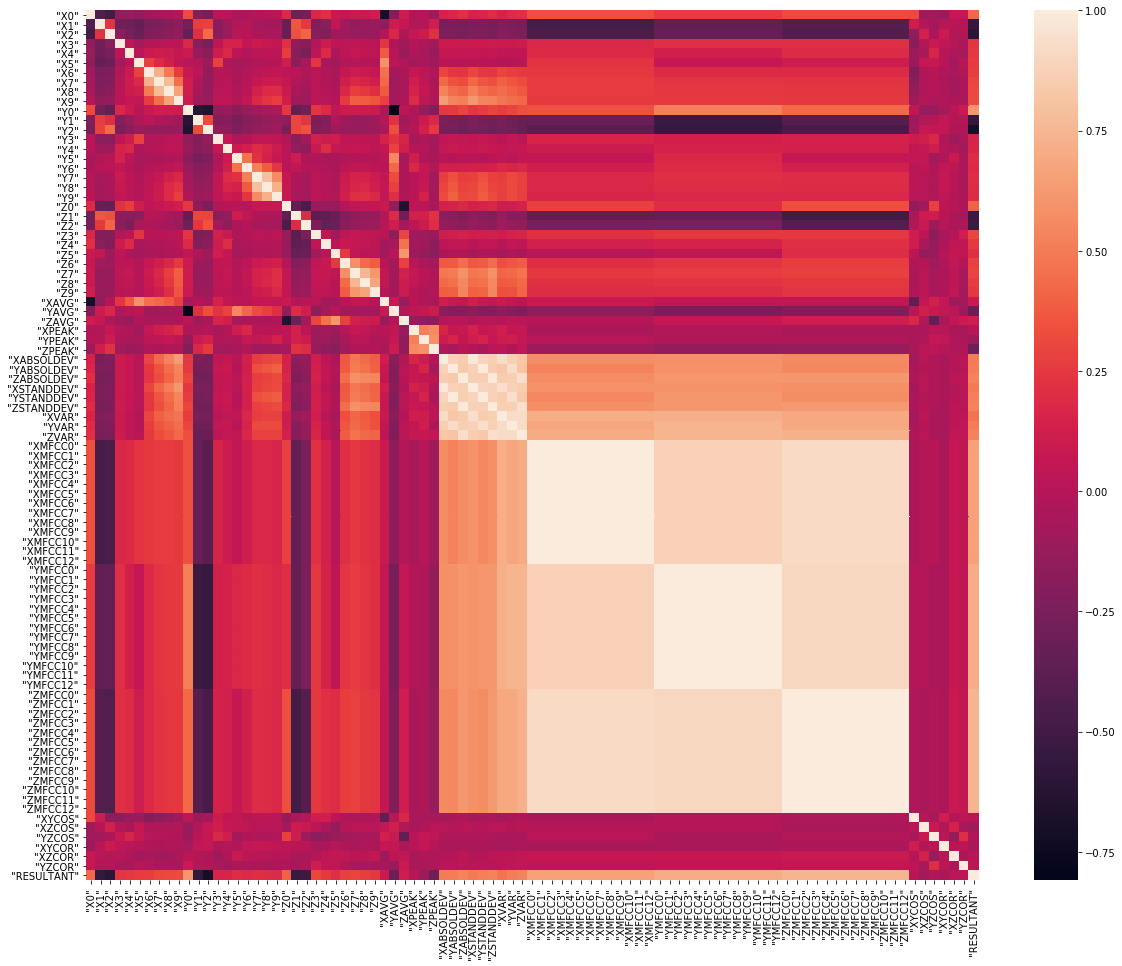

In [18]:
f, ax = plt.subplots(figsize=(20, 16))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [19]:
df.columns

Index(['"ACTIVITY"', '"X0"', '"X1"', '"X2"', '"X3"', '"X4"', '"X5"', '"X6"',
       '"X7"', '"X8"', '"X9"', '"Y0"', '"Y1"', '"Y2"', '"Y3"', '"Y4"', '"Y5"',
       '"Y6"', '"Y7"', '"Y8"', '"Y9"', '"Z0"', '"Z1"', '"Z2"', '"Z3"', '"Z4"',
       '"Z5"', '"Z6"', '"Z7"', '"Z8"', '"Z9"', '"XAVG"', '"YAVG"', '"ZAVG"',
       '"XPEAK"', '"YPEAK"', '"ZPEAK"', '"XABSOLDEV"', '"YABSOLDEV"',
       '"ZABSOLDEV"', '"XSTANDDEV"', '"YSTANDDEV"', '"ZSTANDDEV"', '"XVAR"',
       '"YVAR"', '"ZVAR"', '"XMFCC0"', '"XMFCC1"', '"XMFCC2"', '"XMFCC3"',
       '"XMFCC4"', '"XMFCC5"', '"XMFCC6"', '"XMFCC7"', '"XMFCC8"', '"XMFCC9"',
       '"XMFCC10"', '"XMFCC11"', '"XMFCC12"', '"YMFCC0"', '"YMFCC1"',
       '"YMFCC2"', '"YMFCC3"', '"YMFCC4"', '"YMFCC5"', '"YMFCC6"', '"YMFCC7"',
       '"YMFCC8"', '"YMFCC9"', '"YMFCC10"', '"YMFCC11"', '"YMFCC12"',
       '"ZMFCC0"', '"ZMFCC1"', '"ZMFCC2"', '"ZMFCC3"', '"ZMFCC4"', '"ZMFCC5"',
       '"ZMFCC6"', '"ZMFCC7"', '"ZMFCC8"', '"ZMFCC9"', '"ZMFCC10"',
       '"ZMFCC11"', '

In [20]:
df.drop(df.iloc[:, 43:-8], inplace = True, axis = 1)
df.shape

(75099, 51)

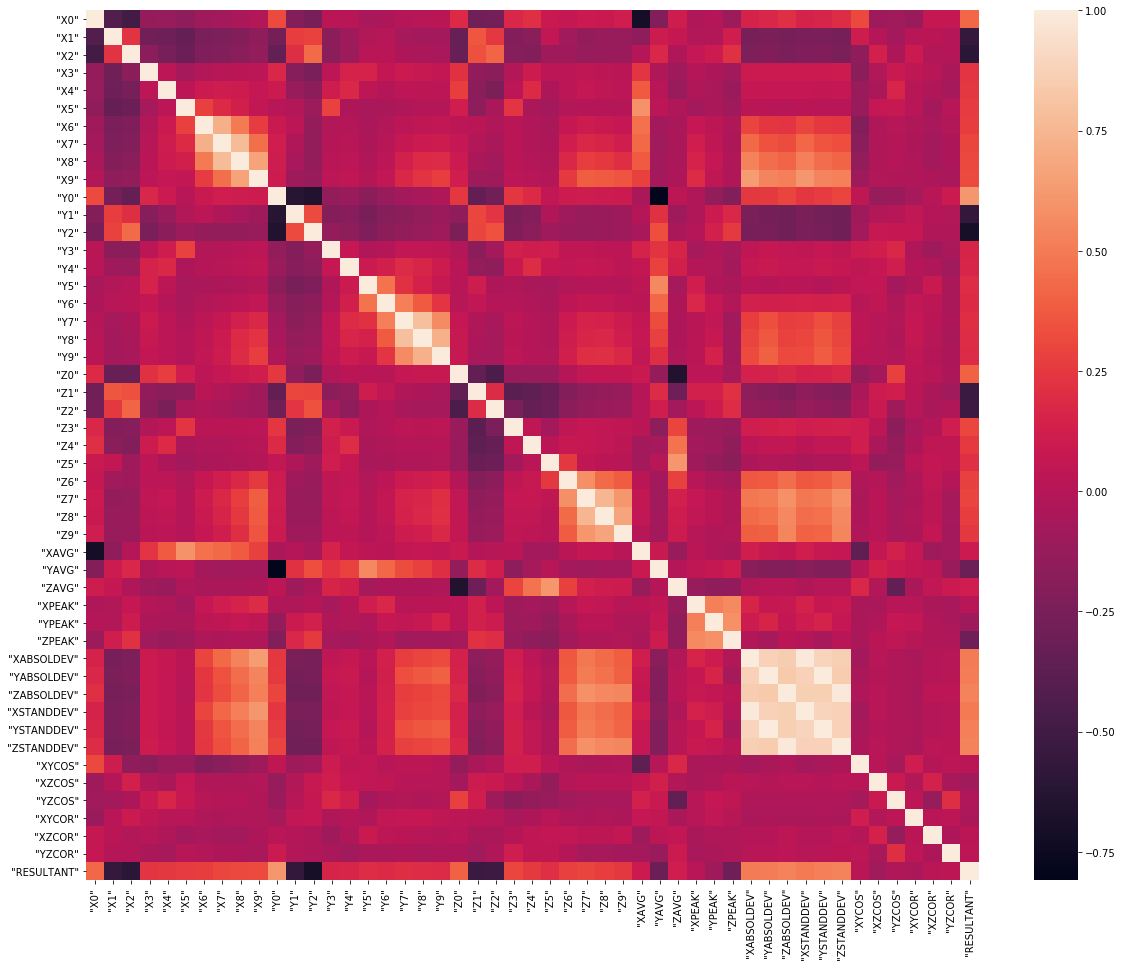

In [21]:
f, ax = plt.subplots(figsize=(20, 16))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [22]:
# Initialize Spark Session
conf = pyspark.SparkConf().setAll([
    ('spark.master', 'local[*]'),
    ('spark.app.name', 'PySpark DSE230 Final')])

try: 
    if type(spark) == 'pyspark.sql.session.SparkSession':
        spark.stop()
        spark = SparkSession.builder.config(conf=conf).getOrCreate()
except:
    spark = SparkSession.builder.config(conf=conf).getOrCreate()

    print (spark.version, pyspark.version.__version__)

3.1.1 3.1.1


In [23]:
# convert Pandas dataframe to Spark dataframe

#spark_df = spark.createDataFrame(df)

#stringIndexer = StringIndexer(inputCol="ACTIVITY", outputCol="label")
#si_model = stringIndexer.fit(df)
#td = si_model.transform(df)
df.drop(df.iloc[:, 43:-8], inplace = True, axis = 1)

In [24]:
# separate data into individual descriptives data frames

spark_df_accel_watch = spark.createDataFrame(df_accel_watch.drop(df_accel_watch.iloc[:, 43:-8], axis = 1))
spark_df_gyro_watch = spark.createDataFrame(df_accel_phone.drop(df_accel_phone.iloc[:, 43:-8], axis = 1))
spark_df_accel_phone = spark.createDataFrame(df_gyro_watch.drop(df_gyro_watch.iloc[:, 43:-8], axis = 1))
spark_df_gyro_phone = spark.createDataFrame(df_gyro_phone.drop(df_gyro_phone.iloc[:, 43:-8], axis = 1))

spark_df_accel_watch = spark_df_accel_watch.withColumn('device_type', lit('watch')).withColumn('sensor_type', lit('accelerometer'))
spark_df_gyro_watch = spark_df_gyro_watch.withColumn('device_type', lit('watch')).withColumn('sensor_type', lit('gyroscope'))
spark_df_accel_phone = spark_df_accel_phone.withColumn('device_type', lit('phone')).withColumn('sensor_type', lit('accelerometer'))
spark_df_gyro_phone = spark_df_gyro_phone.withColumn('device_type', lit('phone')).withColumn('sensor_type', lit('gyroscope'))

#spark_df_gyro_watch = spark_df.select('*').where((spark_df.device_type == 'watch') & (spark_df.sensor_type == 'gyroscope'))
#spark_df_accel_phone = spark_df.select('*').where((spark_df.device_type == 'phone') & (spark_df.sensor_type == 'accelerometer'))
#spark_df_gyro_phone = spark_df.select('*').where((spark_df.device_type == 'phone') & (spark_df.sensor_type == 'gyroscope'))

In [25]:
spark_df_accel_watch.show(1)

+----------+----+----+----+-----+-----+----+----+-----+-----+----+-----+----+-----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+----+----+----+----+------+--------+--------+-------+-------+-------+-----------+-----------+-----------+-----------+-----------+-----------+---------+---------+---------+---------+----------+---------+-----------+-------+-----------+-------------+
|"ACTIVITY"|"X0"|"X1"|"X2"| "X3"| "X4"|"X5"|"X6"| "X7"| "X8"|"X9"| "Y0"|"Y1"| "Y2"|"Y3"|"Y4"|"Y5"|"Y6"|"Y7"|"Y8"|"Y9"|"Z0"|"Z1"|"Z2"| "Z3"| "Z4"|"Z5"|"Z6"|"Z7"|"Z8"|"Z9"|"XAVG"|  "YAVG"|  "ZAVG"|"XPEAK"|"YPEAK"|"ZPEAK"|"XABSOLDEV"|"YABSOLDEV"|"ZABSOLDEV"|"XSTANDDEV"|"YSTANDDEV"|"ZSTANDDEV"|  "XYCOS"|  "XZCOS"|  "YZCOS"|  "XYCOR"|   "XZCOR"|  "YZCOR"|"RESULTANT"|"class"|device_type|  sensor_type|
+----------+----+----+----+-----+-----+----+----+-----+-----+----+-----+----+-----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+----+----+----+----+------+--------+--------+-------

In [26]:
spark_df_accel_watch.select('"ACTIVITY"').show(1)

+----------+
|"ACTIVITY"|
+----------+
|         A|
+----------+
only showing top 1 row



In [27]:
stringIndexer = StringIndexer(inputCol='"ACTIVITY"', outputCol='label', stringOrderType ='alphabetAsc')
si_model = stringIndexer.fit(spark_df_accel_watch)

spark_df_accel_watch = si_model.transform(spark_df_accel_watch)
spark_df_gyro_watch = si_model.transform(spark_df_gyro_watch)
spark_df_accel_phone = si_model.transform(spark_df_accel_phone)
spark_df_gyro_phone = si_model.transform(spark_df_gyro_phone)

In [28]:
# conduct data pre-processing in Spark

train_df_accel_watch, test_df_accel_watch = spark_preprocessing(spark_df_accel_watch)
train_df_gyro_watch, test_df_gyro_watch = spark_preprocessing(spark_df_gyro_watch)
train_df_accel_phone, test_df_accel_phone = spark_preprocessing(spark_df_accel_phone)
train_df_gyro_phone, test_df_gyro_phone = spark_preprocessing(spark_df_gyro_phone)

0 rows dropped for having NA values
0 rows dropped for having NA values
0 rows dropped for having NA values
0 rows dropped for having NA values


In [29]:
train_df_accel_watch.show(1)

+--------+---+---+---+---+---+----+----+----+----+---+----+----+----+----+---+---+---+---+---+---+-----+-----+-----+-----+---+---+---+---+---+---+-------+--------+--------+-----+-------+-------+---------+---------+---------+---------+---------+---------+---------+---------+--------+--------+---------+--------+---------+-----+-----------+-------------+-----+--------------------+--------------------+
|ACTIVITY| X0| X1| X2| X3| X4|  X5|  X6|  X7|  X8| X9|  Y0|  Y1|  Y2|  Y3| Y4| Y5| Y6| Y7| Y8| Y9|   Z0|   Z1|   Z2|   Z3| Z4| Z5| Z6| Z7| Z8| Z9|   XAVG|    YAVG|    ZAVG|XPEAK|  YPEAK|  ZPEAK|XABSOLDEV|YABSOLDEV|ZABSOLDEV|XSTANDDEV|YSTANDDEV|ZSTANDDEV|    XYCOS|    XZCOS|   YZCOS|   XYCOR|    XZCOR|   YZCOR|RESULTANT|class|device_type|  sensor_type|label|       featureVector|featureVector_scaled|
+--------+---+---+---+---+---+----+----+----+----+---+----+----+----+----+---+---+---+---+---+---+-----+-----+-----+-----+---+---+---+---+---+---+-------+--------+--------+-----+-------+-------+--

In [ ]:
%%time
# test which model performs best for each of the data descriptives

feature_col = 'featureVector_scaled'
label_col = 'label'
evaluation_metric = 'accuracy'

accel_watch_results, accel_watch_rfmodel = classifier_ensemble(train_df_accel_watch, test_df_accel_watch)
gyro_watch_results, gyro_watch_rfmodel = classifier_ensemble(train_df_gyro_watch, test_df_gyro_watch)
accel_phone_results, accel_phone_rfmodel = classifier_ensemble(train_df_accel_phone, test_df_accel_phone)
gyro_phone_results, gyro_phone_rfmodel = classifier_ensemble(train_df_gyro_phone, test_df_gyro_phone)

In [ ]:
list(train_df_accel_watch.columns)[1:-6]

In [ ]:
for model in [accel_watch_rfmodel, gyro_watch_rfmodel, accel_phone_rfmodel, gyro_phone_rfmodel]:
    print(pd.DataFrame(model.featureImportances.toArray(), list(train_df_accel_watch.columns)[1:-6]).sort_values(0, ascending=False)[:20].sum())
    print(pd.DataFrame(model.featureImportances.toArray(), list(train_df_accel_watch.columns)[1:-6]).sort_values(0, ascending=False).head(20))

In [ ]:
train_df_accel_watch.show(1)

In [ ]:
# Set up data / variables for ML training
train_data = train_df_accel_watch
test_data = test_df_accel_watch

feature_col = 'featureVector_scaled'
label_col = 'label'
evaluation_metric = 'accuracy'

train_data = train_data.select(feature_col, label_col). \
                        withColumnRenamed(feature_col, 'features'). \
                        withColumnRenamed(label_col, 'label')
test_data = test_data.select(feature_col, label_col). \
                      withColumnRenamed(feature_col, 'features'). \
                      withColumnRenamed(label_col, 'label')

In [ ]:
%%time
# Classification - One v. Rest - Logistic Regression

classifier = LogisticRegression(maxIter=10000)

#lr_ovr = OneVsRest(classifier=classifier)
#lr_model = lr_ovr.fit(train_data)
#lr_eval_data = lr_model.transform(test_data)

#lr_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
#lr_evaluator.evaluate(lr_eval_data)

In [ ]:
%%time
# Classification - One v. Rest - Support Vector Classifier

classifier=LinearSVC(maxIter=100, regParam=.000000001) 

#svc_ovr = OneVsRest(classifier=classifier)
#svc_model = svc_ovr.fit(train_data)
#svc_eval_data = svc_model.transform(test_data)

#svc_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
#svc_evaluator.evaluate(svc_eval_data)

In [ ]:
%%time
# Classification - Random Forest

#rf = RandomForestClassifier(numTrees=30, maxDepth=10, seed=seed)

#rf_model = rf.fit(train_data)
#rf_eval_data = rf_model.transform(test_data)

#rf_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
#rf_evaluator.evaluate(rf_eval_data)

In [ ]:
#print(set(train_df_accel_watch.columns[1:-3]) - set(list(df.columns)[1:-1]))
#print(set(list(df.columns)[1:-1]) - set(train_df_accel_watch.columns[1:-3]))
#set(train_df_accel_watch.columns[1:-6]) == set(list(df.columns)[1:-1])

In [ ]:
#pd.DataFrame(rf_model.featureImportances.toArray(), list(df.columns)[1:-4]).sort_values(0, ascending=False)[:20].sum()

In [ ]:
#pd.DataFrame(rf_model.featureImportances.toArray(), list(df.columns)[1:-4]).sort_values(0, ascending=False).head(20)

In [ ]:
# visualize prediction / model performance

In [ ]:
#######spark.stop()